### Fraudulent Transaction Detection in Credit Cards -- Introduction

The problem described in this set of notebooks is 'Fraudulent Transaction Detection in Credit Cards'.

The synthetic credit card transaction dataset for the same is obtained from GitHub.
https://github.com/IBM/TabFormer/tree/main/data/credit_card
The dataset includes 24M records with 15 columns.

The problem shall be approached in 4 steps:

    1. Exploratory Data Analysis
    
    2. Model Analysis
    
    3. Model Enhancement and Hyperparameter Tuning
    
    4. Evaluating Final Metrics for the Obtained Model

The purpose of this notebook is 'Exploratory Data Analysis'. Here, we will try to understand the dataset and perform necessary data preprocessing operations in order to come up with a solution for the problem.

In [1]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn import preprocessing
from sklearn import feature_extraction
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

### Reading the dataset into pandas

In [2]:
df = pd.read_csv('Datasets/card_fraud.csv')
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


### Dataset Description

In [3]:
df.describe()

,User,Card,Year,Month,Day,Merchant Name,Zip,MCC
count,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.150876e+07,2.438690e+07
mean,1.001019e+03,1.351366e+00,2.011955e+03,6.525064e+00,1.571812e+01,-4.769230e+17,5.095644e+04,5.561171e+03
std,5.694612e+02,1.407154e+00,5.105921e+00,3.472355e+00,8.794073e+00,4.758940e+18,2.939707e+04,8.793154e+02
min,0.000000e+00,0.000000e+00,1.991000e+03,1.000000e+00,1.000000e+00,-9.222899e+18,5.010000e+02,1.711000e+03
25%,5.100000e+02,0.000000e+00,2.008000e+03,3.000000e+00,8.000000e+00,-4.500543e+18,2.837400e+04,5.300000e+03
50%,1.006000e+03,1.000000e+00,2.013000e+03,7.000000e+00,1.600000e+01,-7.946765e+17,4.674200e+04,5.499000e+03
75%,1.477000e+03,2.000000e+00,2.016000e+03,1.000000e+01,2.300000e+01,3.189517e+18,7.756400e+04,5.812000e+03
max,1.999000e+03,8.000000e+00,2.020000e+03,1.200000e+01,3.100000e+01,9.223292e+18,9.992800e+04,9.402000e+03


In [4]:
df.shape

(24386900, 15)

In [5]:
df.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Time               object
Amount             object
Use Chip           object
Merchant Name       int64
Merchant City      object
Merchant State     object
Zip               float64
MCC                 int64
Errors?            object
Is Fraud?          object
dtype: object

In [6]:
classes=df['Is Fraud?'].value_counts()
normal_share=classes[0]/df['Is Fraud?'].count()*100
fraud_share=classes[1]/df['Is Fraud?'].count()*100
print(normal_share)
print(fraud_share)

99.87797957099919
0.12202042900081601


In [7]:
normal= classes[0]
fraud = classes[1]
print(normal)
print(fraud)

24357143
29757


### Data Cleaning

In [8]:
#Checking for null values 
df.isnull().sum().sort_values(ascending=False)

Errors?           23998469
Zip                2878135
Merchant State     2720821
User                     0
Card                     0
Year                     0
Month                    0
Day                      0
Time                     0
Amount                   0
Use Chip                 0
Merchant Name            0
Merchant City            0
MCC                      0
Is Fraud?                0
dtype: int64

We can see that there are null values in the dataset. For the 'Errors?' column, we can safely replace the null value with '0' as they get counted as 'No error returned'. For null Merchant States and Zip, we need to find out what the null values mean.

Before getting into handling null values, we will first clean up the column names of the dataset for the sake of convenience in querying operations

In [9]:
#Cleaning the column names
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.replace('?','')

In [10]:
df.query('Merchant_State.isnull()', engine='python')

,User,Card,Year,Month,Day,Time,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud
11,0,0,2002,9,5,20:41,$53.91,Online Transaction,-9092677072201095172,ONLINE,NaN,NaN,4900,NaN,No
24,0,0,2002,9,9,20:02,$144.90,Online Transaction,-8338381919281017248,ONLINE,NaN,NaN,4899,NaN,No
85,0,0,2002,9,30,06:21,$127.32,Online Transaction,-7421093378627544099,ONLINE,NaN,NaN,5311,NaN,No
99,0,0,2002,10,6,06:14,$139.39,Online Transaction,-7421093378627544099,ONLINE,NaN,NaN,5311,NaN,No
106,0,0,2002,10,9,08:16,$53.09,Online Transaction,-4956618006720593695,ONLINE,NaN,NaN,5193,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386877,1999,1,2020,2,24,20:04,$55.79,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No
24386879,1999,1,2020,2,25,07:06,$43.08,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No
24386880,1999,1,2020,2,25,07:34,$43.76,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No
24386884,1999,1,2020,2,26,07:43,$45.18,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No


In [11]:
df.query('Zip.isnull()', engine='python')

,User,Card,Year,Month,Day,Time,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud
11,0,0,2002,9,5,20:41,$53.91,Online Transaction,-9092677072201095172,ONLINE,NaN,NaN,4900,NaN,No
24,0,0,2002,9,9,20:02,$144.90,Online Transaction,-8338381919281017248,ONLINE,NaN,NaN,4899,NaN,No
85,0,0,2002,9,30,06:21,$127.32,Online Transaction,-7421093378627544099,ONLINE,NaN,NaN,5311,NaN,No
99,0,0,2002,10,6,06:14,$139.39,Online Transaction,-7421093378627544099,ONLINE,NaN,NaN,5311,NaN,No
106,0,0,2002,10,9,08:16,$53.09,Online Transaction,-4956618006720593695,ONLINE,NaN,NaN,5193,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386877,1999,1,2020,2,24,20:04,$55.79,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No
24386879,1999,1,2020,2,25,07:06,$43.08,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No
24386880,1999,1,2020,2,25,07:34,$43.76,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No
24386884,1999,1,2020,2,26,07:43,$45.18,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No


We see that a lot of Merchant City values are online for both, we can check if all the values are online by value_counts() Method

In [12]:
(df.query('Merchant_State.isnull()', engine='python'))['Merchant_City'].value_counts()

 ONLINE    2720821
Name: Merchant_City, dtype: int64

In [13]:
(df.query('Zip.isnull()', engine='python'))['Merchant_City'].value_counts()

 ONLINE         2720821
Cancun            16977
Mexico City        8878
Rome               8730
Toronto            7783
                 ...   
Nuku Alofa            2
Kinshasa              2
Gaborone              1
Asuncion              1
South Tarawa          1
Name: Merchant_City, Length: 193, dtype: int64

In [14]:
df = df.replace(' ONLINE', 'ONLINE')

Since all merchant states where value is null have city online, we can replace the states as online. For Zip, since zip is a categorical attribute, we can safely replace all null values with the corresponding city value

In [15]:
df['Merchant_State'] = df['Merchant_State'].replace(np.nan, 'ONLINE')
df

,User,Card,Year,Month,Day,Time,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,2,27,22:23,$-54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386896,1999,1,2020,2,27,22:24,$54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386897,1999,1,2020,2,28,07:43,$59.15,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No
24386898,1999,1,2020,2,28,20:10,$43.12,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No


In [16]:
df['Errors'] = df['Errors'].replace(np.nan, 0)

In [17]:
df["Zip"].fillna(df["Merchant_City"], inplace=True)

We have obtained a dataframe without null values. 

Now, as listed above, there is a huge difference in the number of Normal transactions and Fraud transactions. This can be seen by plotting Normal Transactions Class on a y scale of 25 million and Fraud Transactions on a y scale of 500,000

Text(0, 0.5, 'Fraud Trans')

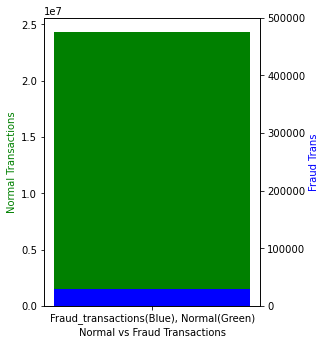

In [18]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
x1 = ['Normal_trans']
x2 = ['Fraud_transactions(Blue), Normal(Green)']
y1 = normal
y2 = fraud

fig, ax1 = plt.subplots()
fig.set_figwidth(3)
plt.subplots_adjust(left=1, bottom=0, right=2, top=1, wspace=5, hspace=1)
ax2 = ax1.twinx()


ax1.bar(x1, y1, width=0.2, color='g')
ax2.bar(x2, y2, width=0.2, color='b')

ax2.set_ylim([0, 500000])

ax1.set_xlabel('Normal vs Fraud Transactions')
ax1.set_ylabel('Normal Transactions', color='g')

ax2.set_ylabel('Fraud Trans', color='b')

We can see that the data is highly skewed, therefore we need to sample the data and reduce the skewness by including more Fraud transactions. Also, the dataset is quite large (approx 24 million values), so we need to sample the data to load into memory.

### Data Sampling 1 - Naive Model

In [19]:
df.nunique()

User                2000
Card                   9
Year                  30
Month                 12
Day                   31
Time                1440
Amount             98953
Use_Chip               3
Merchant_Name     100343
Merchant_City      13429
Merchant_State       224
Zip                27514
MCC                  109
Errors                24
Is_Fraud               2
dtype: int64

Now, we will sample five smaller datasets out of our dataframe, such that all of the Merchant_State are included in each of the dataframe. We must also ensure that all fraudulent transactions are included in each of the samples, since there are only 29757

In [20]:
backup = df.copy(deep=True)

In [21]:
#frauds = df.query('Is_Fraud == "Yes"')
b = backup.query('Is_Fraud == "Yes"')['Merchant_State'].value_counts().rename_axis('Merchant_State').reset_index(name='Frauds')
a = backup['Merchant_State'].value_counts().rename_axis('Merchant_State').reset_index(name='Total')

a.columns = ['Merchant_State','Total']
b.columns = ['Merchant_State','Frauds']
state_counts = a.merge(b , how="outer", on=['Merchant_State','Merchant_State'])
state_counts['Density'] = state_counts['Frauds']/state_counts['Total']
state_counts = state_counts.sort_values(['Density'], ascending=(False))
state_counts.head(10)

#ax = state_counts.head(5)[['Total','Frauds']].plot(kind='bar')
#ax.set_xticklabels(state_counts['Merchant_State'].head(5))

,Merchant_State,Total,Frauds,Density
136,Tuvalu,59,59.0,1.000000
84,Algeria,654,629.0,0.961774
94,Haiti,446,375.0,0.840807
147,Fiji,40,32.0,0.800000
105,Nigeria,233,143.0,0.613734
92,Turkey,472,257.0,0.544492
54,Italy,8730,4682.0,0.536312
59,Japan,3955,49.0,0.012389
0,ONLINE,2720821,18349.0,0.006744
49,Mexico,47152,272.0,0.005769


We can see that the frauds depend a lot on the Merchant State by calculating density of fraud in each state. We will plot the 5 most frequent states with frauds.

[Text(0, 0, 'Tuvalu'),
 Text(1, 0, 'Algeria'),
 Text(2, 0, 'Haiti'),
 Text(3, 0, 'Fiji'),
 Text(4, 0, 'Nigeria')]

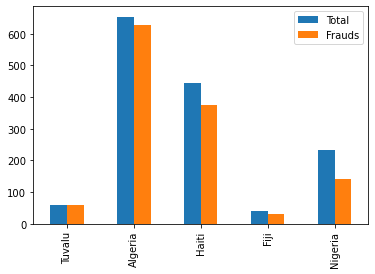

In [22]:
ax = state_counts.head(5)[['Total','Frauds']].plot(kind='bar')
ax.set_xticklabels(state_counts['Merchant_State'].head(5))

just by exploratory analysis, we can form a model that categorizes a transaction as fraudulent if it is from one of the top 7 states

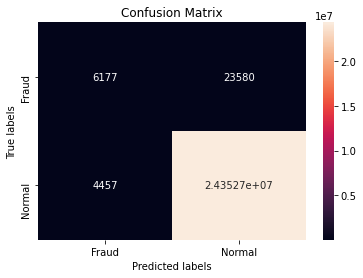

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = [[6177,23580],[4457,24352686]]

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Fraud', 'Normal']); ax.yaxis.set_ticklabels(['Fraud', 'Normal']);

Since the data is imbalanced, accuracy cannot be relied on so we will see the precision and recall values of this model. From the confusion matrix above, we can see that for our naive model:

Precision = 0.2076

Recall = 0.5809

F-score = 0.3059

Therefore, to build upon this model and increase its score, we will do a stratified random sampling of our dataset by Merchant_State, after including all fraudulent transactions in each sampled dataset.

Note: We could've also gone for all online transactions as fraudulent, but such a model will return a lot of False Positives since there are a total of 2720821 online transactions, almost 10 times as much as the total number of frauds in the dataset!

### Data Sampling 2 - Random Stratified Sampling with Undersampling of majority class

In [24]:
frauds_df = df[((df['Is_Fraud'] == 'Yes') == True)]
frauds_df

,User,Card,Year,Month,Day,Time,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud
4099,0,0,2015,11,15,12:55,$287.13,Online Transaction,-8194607650924472520,ONLINE,ONLINE,ONLINE,3001,0,Yes
4100,0,0,2015,11,15,13:19,$2.41,Online Transaction,-7759074308363763111,ONLINE,ONLINE,ONLINE,5651,0,Yes
4101,0,0,2015,11,16,09:41,$50.81,Online Transaction,-551332107213382088,ONLINE,ONLINE,ONLINE,4411,0,Yes
4102,0,0,2015,11,16,09:46,$248.36,Online Transaction,4872340518840476610,ONLINE,ONLINE,ONLINE,5732,0,Yes
4103,0,0,2015,11,16,11:20,$473.00,Online Transaction,-8566951830324093739,ONLINE,ONLINE,ONLINE,3640,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24375668,1997,2,2016,9,4,10:45,$1.25,Online Transaction,6455213054093379528,ONLINE,ONLINE,ONLINE,5815,0,Yes
24375670,1997,2,2016,9,4,12:30,$116.66,Online Transaction,822647939787511611,ONLINE,ONLINE,ONLINE,5311,0,Yes
24375671,1997,2,2016,9,4,12:40,$359.99,Online Transaction,8080934608468946743,ONLINE,ONLINE,ONLINE,5310,0,Yes
24375672,1997,2,2016,9,4,13:45,$351.51,Online Transaction,-4282466774399734331,ONLINE,ONLINE,ONLINE,4829,0,Yes


In [25]:
df1 = frauds_df.copy(deep=True)
df2 = frauds_df.copy(deep=True)
df3 = frauds_df.copy(deep=True)
df4 = frauds_df.copy(deep=True)
df5 = frauds_df.copy(deep=True)

df = df[((df['Is_Fraud'] == 'No') == True)]
df.Is_Fraud.value_counts()

No    24357143
Name: Is_Fraud, dtype: int64

In [26]:
df.dtypes

User               int64
Card               int64
Year               int64
Month              int64
Day                int64
Time              object
Amount            object
Use_Chip          object
Merchant_Name      int64
Merchant_City     object
Merchant_State    object
Zip               object
MCC                int64
Errors            object
Is_Fraud          object
dtype: object

In [27]:
df_new = pd.DataFrame(columns=df.columns)
df_new

,User,Card,Year,Month,Day,Time,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud


In [28]:
df.shape

(24357143, 15)

In [29]:
total = df['Merchant_State'].nunique()
total

223

In [30]:
from sklearn.utils import shuffle

string_attributes = ['Merchant_State']
num_attributes = ['User', 'Card', 'Year', 'Month', 'Day']

i=1
total = df['Merchant_State'].nunique()


for col in string_attributes:
    for value in (df[col].unique()):
        #print("for " + col + ": " + str(value) + ": " + str(df.query('(' + col + ' == "' + str(value) + '") & Is_Fraud == "Yes"', engine='python').shape[0]))
        print(value + " " + str(i) + " of " + str(total))
        i = i+1
        #rows = df.query('(' + col + ' == "' + str(value) + '")') # & Is_Fraud == "Yes"', engine='python').shape[0]
        temp_df = df[(df[col] == str(value)) == True]
        count = temp_df.shape[0]
        if(count/10 > 100):
            count = int(count/100)
        temp_df = shuffle(temp_df)
        df1 = df1.append(temp_df[:count])
        temp_df = shuffle(temp_df)
        df2 = df2.append(temp_df[:count])
        temp_df = shuffle(temp_df)
        df3 = df3.append(temp_df[:count])
        temp_df = shuffle(temp_df)
        df4 = df4.append(temp_df[:count])
        temp_df = shuffle(temp_df)
        df5 = df5.append(temp_df[:count])

CA 1 of 223
ONLINE 2 of 223
NE 3 of 223
IL 4 of 223
MO 5 of 223
Switzerland 6 of 223
IA 7 of 223
TX 8 of 223
Estonia 9 of 223
NJ 10 of 223
NV 11 of 223
NY 12 of 223
Japan 13 of 223
AZ 14 of 223
UT 15 of 223
FL 16 of 223
MI 17 of 223
Mexico 18 of 223
WA 19 of 223
OH 20 of 223
Dominican Republic 21 of 223
NM 22 of 223
China 23 of 223
SC 24 of 223
AK 25 of 223
PA 26 of 223
VA 27 of 223
Portugal 28 of 223
HI 29 of 223
CT 30 of 223
MA 31 of 223
MN 32 of 223
CO 33 of 223
Italy 34 of 223
GA 35 of 223
Philippines 36 of 223
Jamaica 37 of 223
AR 38 of 223
Canada 39 of 223
OR 40 of 223
WI 41 of 223
NC 42 of 223
France 43 of 223
WV 44 of 223
Norway 45 of 223
ME 46 of 223
NH 47 of 223
VT 48 of 223
MD 49 of 223
AL 50 of 223
KY 51 of 223
TN 52 of 223
MS 53 of 223
New Zealand 54 of 223
Netherlands 55 of 223
KS 56 of 223
ND 57 of 223
DC 58 of 223
Sierra Leone 59 of 223
MT 60 of 223
South Korea 61 of 223
Spain 62 of 223
OK 63 of 223
Egypt 64 of 223
WY 65 of 223
ID 66 of 223
Indonesia 67 of 223
RI 68 of 

In [31]:
df1

,User,Card,Year,Month,Day,Time,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud
4099,0,0,2015,11,15,12:55,$287.13,Online Transaction,-8194607650924472520,ONLINE,ONLINE,ONLINE,3001,0,Yes
4100,0,0,2015,11,15,13:19,$2.41,Online Transaction,-7759074308363763111,ONLINE,ONLINE,ONLINE,5651,0,Yes
4101,0,0,2015,11,16,09:41,$50.81,Online Transaction,-551332107213382088,ONLINE,ONLINE,ONLINE,4411,0,Yes
4102,0,0,2015,11,16,09:46,$248.36,Online Transaction,4872340518840476610,ONLINE,ONLINE,ONLINE,5732,0,Yes
4103,0,0,2015,11,16,11:20,$473.00,Online Transaction,-8566951830324093739,ONLINE,ONLINE,ONLINE,3640,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22913565,1880,6,2010,10,12,12:21,$18.35,Swipe Transaction,8263593753316459353,Andorra La Vella,Andorra,Andorra La Vella,5411,0,No
22901189,1880,1,2010,10,14,13:03,$26.22,Swipe Transaction,8263593753316459353,Andorra La Vella,Andorra,Andorra La Vella,5411,0,No
22902693,1880,2,2010,10,16,12:41,$29.29,Swipe Transaction,8263593753316459353,Andorra La Vella,Andorra,Andorra La Vella,5411,0,No
22913568,1880,6,2010,10,13,13:25,$26.13,Swipe Transaction,8263593753316459353,Andorra La Vella,Andorra,Andorra La Vella,5411,0,No


now we have 5 different datasets with comparatively balanced data, which are also representative of the main dataset. We will predict whether a transaction is fraud or not on these. We will first export these to CSVs, then by feature engineering, one hot encode all the Merchant States and Use_Chip. We need to one hot encode these columns as our naive model is based on Merchant States. The other categories will be replaced by their frequency values in order for sklearn to process them. This may lead to some loss of information, but our main column - Merchant_States along with other numerical attributes, will be preserved

In [32]:
df1.dtypes

User               int64
Card               int64
Year               int64
Month              int64
Day                int64
Time              object
Amount            object
Use_Chip          object
Merchant_Name      int64
Merchant_City     object
Merchant_State    object
Zip               object
MCC                int64
Errors            object
Is_Fraud          object
dtype: object

### Data Cleaning and One-Hot-Encoding

Now we remove the $ sign from amount column and encode all other categorical attributes. For Time, only the hour of the day is relevant for our analysis, so we keep just that.

In [33]:
###Encoding other features
dfs = [df1,df2,df3,df4,df5]

#df['Time'] = pd.to_datetime(df['Time'])
#df['Time'] = df['Time'].dt.hour
#df['Amount'] = df['Amount'].replace('[\$,]', '', regex=True).astype(float)
cat_attributes = ['Merchant_City', 'Zip', 'Errors']


for currDF in dfs:
    currDF['Time'] = pd.to_datetime(currDF['Time'])
    currDF['Time'] = currDF['Time'].dt.hour
    currDF['Amount'] = currDF['Amount'].replace('[\$,]', '', regex=True).astype(float)
    for col in cat_attributes:
        df_frequency_map = currDF[col].value_counts().to_dict()
        currDF[col] = currDF[col].map(df_frequency_map)

df1

,User,Card,Year,Month,Day,Time,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud
4099,0,0,2015,11,15,12,287.13,Online Transaction,-8194607650924472520,45373,ONLINE,45373,3001,283908,Yes
4100,0,0,2015,11,15,13,2.41,Online Transaction,-7759074308363763111,45373,ONLINE,45373,5651,283908,Yes
4101,0,0,2015,11,16,9,50.81,Online Transaction,-551332107213382088,45373,ONLINE,45373,4411,283908,Yes
4102,0,0,2015,11,16,9,248.36,Online Transaction,4872340518840476610,45373,ONLINE,45373,5732,283908,Yes
4103,0,0,2015,11,16,11,473.00,Online Transaction,-8566951830324093739,45373,ONLINE,45373,3640,283908,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22913565,1880,6,2010,10,12,12,18.35,Swipe Transaction,8263593753316459353,32,Andorra,32,5411,283908,No
22901189,1880,1,2010,10,14,13,26.22,Swipe Transaction,8263593753316459353,32,Andorra,32,5411,283908,No
22902693,1880,2,2010,10,16,12,29.29,Swipe Transaction,8263593753316459353,32,Andorra,32,5411,283908,No
22913568,1880,6,2010,10,13,13,26.13,Swipe Transaction,8263593753316459353,32,Andorra,32,5411,283908,No


In [34]:
df1.to_csv('Datasets/sampled_cc_1.csv', sep=',', encoding='utf-8')
df2.to_csv('Datasets/sampled_cc_2.csv', sep=',', encoding='utf-8')
df3.to_csv('Datasets/sampled_cc_3.csv', sep=',', encoding='utf-8')
df4.to_csv('Datasets/sampled_cc_4.csv', sep=',', encoding='utf-8')
df5.to_csv('Datasets/sampled_cc_5.csv', sep=',', encoding='utf-8')

In [2]:
def OHEForDF(input_df):
    ohe = preprocessing.OneHotEncoder(dtype=int, sparse=False, handle_unknown="ignore")


    data = ohe.fit_transform(input_df[["Merchant_State", "Use_Chip", "Card"]])

    input_df.drop(["Merchant_State", "Use_Chip", "Card"], axis=1, inplace=True)
    cats = pd.DataFrame(data, columns=ohe.get_feature_names())
    input_df = pd.concat([cats, input_df], axis=1)
    redundant_rows = len(input_df) - len(input_df)
    input_df.drop(input_df.tail(redundant_rows).index,inplace=True) # drop last n rows
    input_df.columns = [c.replace("x0_", "Merchant_State=").replace("x1_","Use_Chip=").replace("x2_","Card=") for c in input_df.columns]
    #input_df = addAllCols(input_df)
    return input_df

In [4]:
del df
del backup

#df1 = pd.read_csv('Datasets/sampled_cc_1.csv')
#df2 = pd.read_csv('Datasets/sampled_cc_2.csv')
#df3 = pd.read_csv('Datasets/sampled_cc_3.csv')
#df4 = pd.read_csv('Datasets/sampled_cc_4.csv')
#df5 = pd.read_csv('Datasets/sampled_cc_5.csv')
dfs = [df1, df2, df3, df4, df5]
i=1
for currDF in dfs:
    OHEForDF(currDF).to_csv('Datasets/ohe_sampled_cc_' + str(i) + '.csv', sep=',', encoding='utf-8')
    i += 1
    print("done")

done
done
done
done
done


now we have datasets on which we can try running different Machine Learning Algorithms